In [60]:
from IPython.core.display import HTML
HTML(open('../css_styles/custom_style.css', 'r').read())

FileNotFoundError: [Errno 2] No such file or directory: '../css_styles/custom_style.css'

# Breast Cancer Wisconsin (Prognostic) Data Set Information:


<div class="start">Each record represents follow-up data for one breast cancer case. These are consecutive patients seen by Dr. Wolberg since 1984, and include only those cases exhibiting invasive breast cancer and no evidence of distant metastases at the time of diagnosis.</div>

The first 30 features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.


The separation described above was obtained using Multisurface Method-Tree (MSM-T, see [here](https://minds.wisconsin.edu/bitstream/handle/1793/59564/TR1067.pdf?sequence=1)), a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.
The actual linear program used to obtain the separating plane in the 3-dimensional space is that described [here](https://minds.wisconsin.edu/bitstream/handle/1793/59538/TR1054.pdf?sequence=1).


The Recurrence Surface Approximation (RSA) method is a linear programming model which predicts Time To Recur using both recurrent and nonrecurrent cases. See references above for details of the RSA method.


Attribute Information:
<ol>
<li>ID number</li>
<li>Outcome (R = recur, N = nonrecur)</li>
</li>
<li>Ten real-valued features are computed for each cell nucleus:</li>
<ol>
<li>radius (mean of distances from center to points on the perimeter) </li>
<li>texture (standard deviation of gray-scale values)</li>
<li>perimeter</li>
<li>area</li>
<li>smoothness (local variation in radius lengths)</li>
<li>compactness (perimeter$^2$ / area - 1.0)</li>
<li>concavity (severity of concave portions of the contour)</li>
<li>concave points (number of concave portions of the contour) </li>
<li>symmetry</li>
    <li>fractal dimension ("coastline approximation" - 1)</li></ol></ol>
The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

Values for features 3-32 are recoded with four significant digits.
<!-- 
<ol start="34">
<li> Tumor size - diameter of the excised tumor in centimeters</li>
<li> Lymph node status - number of positive axillary lymph nodes
observed at time of surgery</li>    -->
</ol>

## Loading the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import os
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import pylab
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}',r'\sansmath']
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

## Defining some useful functions

In [2]:
import itertools
import seaborn as sns

def get_cmap(n, name='viridis'):
    
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_conf_mat(ax,confusion_mat,
                       target_names,
                       title_name,
                       colmap='Blues',
                       alpha_=1,
                       normalize=True,
                       FS=18):

    accuracy = np.trace(confusion_mat) / float(np.sum(confusion_mat))
    misclassified = 1 - accuracy
    
    cmap = get_cmap(len(target_names)**2, colmap)

    ax.imshow(confusion_mat, interpolation='nearest', cmap=cmap, alpha=alpha_)
    ax.set_title('Confusion matrix of %s'%title_name,fontsize=FS)
    
    if target_names is not None:
        
        tick_marks = np.arange(len(target_names))
        ax.set_xticklabels(target_names, rotation=45,fontsize=int(FS/1.3))
        ax.set_xticks(tick_marks)
        ax.set_yticklabels(target_names,fontsize=int(FS/1.3))
        ax.set_yticks(tick_marks)

    if normalize:
        confusion_mat = confusion_mat.astype('float') \
        / confusion_mat.sum(axis=1)[:, np.newaxis]


    thresh = confusion_mat.max() / 1.5 if normalize else confusion_mat.max() / 2
    for i, j in itertools.product(range(confusion_mat.shape[0]),\
                                  range(confusion_mat.shape[1])):
        if normalize:
            
            ax.text(j, i, "{:0.4f}".format(confusion_mat[i, j]),
                    horizontalalignment="center",
                    color="white" if confusion_mat[i, j] > thresh else "black",
                    fontsize=int(FS/1.5))
        else:
            ax.text(j, i, "{:,}".format(confusion_mat[i, j]),
                    horizontalalignment="center",
                    color="white" if confusion_mat[i, j] > thresh else "black",
                    fontsize=int(FS/1.5))

    ax.set_ylabel('True label',fontsize=int(FS))
    ax.set_xlabel('Predicted label\naccuracy={:0.2f}%; misclassified={:0.2f}%'.\
               format(100*accuracy, 100*misclassified),fontsize=int(FS))

    
def corr(corr, target_names=None,title_name='title',fig_size=(10,12),
             colmap='Blues',alpha_=1,FS=18,masked=True):
    
    fig = plt.figure(figsize=fig_size) 
    gs = fig.add_gridspec(10,100)
    ax = fig.add_subplot(gs[:, :-5])
    cmap = get_cmap(corr.shape[0]**2, colmap)
    np.ones([3,3],dtype=bool)
    mask = np.zeros_like(corr, dtype=np.bool)
    if masked:
        mask[np.triu_indices_from(mask)] = True
    else:
        mask[:] = False
    corr_im = np.ma.masked_where(mask, corr)
    ax.imshow(corr_im, interpolation='nearest', cmap=cmap, alpha=alpha_)
    ax.set_title('Correlation matrix of %s'%title_name,fontsize=FS)

    thresh = corr.max() / 1.5
    for i, j in itertools.product(range(corr.shape[0]),\
                                  range(corr.shape[1])):
        ax.text(j, i, "{:0.2f}".format(corr_im[i, j]),
                        horizontalalignment="center",
                        color="white" if corr_im[i, j] > thresh else "black",
                        alpha=0 if mask[i, j] else 1,
                        fontsize=int(FS/1.5))
    ax.set_xticks([])
    ax.set_yticks([])
    
    if target_names is not None:
        for i in range(len(target_names)):
            ax.text(-0.625, i, "{0:s}".format(target_names[i]),
                            horizontalalignment="right",
                            color= "black",fontsize=int(FS/1.5))
            ax.text(i, len(target_names)-0.375, "{0:s}".format(target_names[i]),
                            verticalalignment="top",rotation=-45,
                            color= "black",fontsize=int(FS/1.5))
        
    norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
    cbar_ax = fig.add_subplot(gs[1:-1, -2:])
    cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=colmap),
                      cax=cbar_ax, orientation='vertical',
                      label='',alpha=1)
    cb.ax.set_ylabel(cb.ax.get_xlabel(),fontsize=12)
    cb.ax.yaxis.set_tick_params(labelsize=FS)
    cb.outline.set_visible(False)
    plt.show()

## Importing the data

In [3]:
df = pd.read_csv('wdbc.data',names=['id','outcome','radius mean','texture mean',
                                    'perimeter mean','area mean','smoothness mean',
                                    'compactness mean','concavity mean',
                                    'num conc por mean','symmetry mean',
                                    'fractal dim mean','radius','texture','perimeter',
                                    'area','smoothness','compactness','concavity',
                                    'num conc por','symmetry','fractal dim',
                                    'radius worst','texture worst','perimeter worst',
                                    'area worst','smoothness worst','compactness worst',
                                    'concavity worst','num conc por worst','symmetry worst',
                                    'fractal dim worst'])

In [96]:
df.head(5)

,id,outcome,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,num conc por mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worst,compactness worst,concavity worst,num conc por worst,symmetry worst,fractal dim worst
0,842302,M,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,...,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119
1,842517,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,...,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089
2,84300903,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,...,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
3,84348301,M,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,...,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173
4,84358402,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,...,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077


We will exclude any cases where there is a missing value. Check all the columns for `NaN`s:

In [97]:
df.isnull().values.any()

False

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  569 non-null    int64  
 1   outcome             569 non-null    object 
 2   radius mean         569 non-null    float64
 3   texture mean        569 non-null    float64
 4   perimeter mean      569 non-null    float64
 5   area mean           569 non-null    float64
 6   smoothness mean     569 non-null    float64
 7   compactness mean    569 non-null    float64
 8   concavity mean      569 non-null    float64
 9   num conc por mean   569 non-null    float64
 10  symmetry mean       569 non-null    float64
 11  fractal dim mean    569 non-null    float64
 12  radius              569 non-null    float64
 13  texture             569 non-null    float64
 14  perimeter           569 non-null    float64
 15  area                569 non-null    float64
 16  smoothne

We can safely drop the **id** column as it's useless in our analysis. We also transform the **outcome** column labels to numerics

In [4]:
df.drop("id",axis=1,inplace=True)
df.head(5)

,outcome,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,num conc por mean,symmetry mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worst,compactness worst,concavity worst,num conc por worst,symmetry worst,fractal dim worst
0,M,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,...,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119
1,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,...,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089
2,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,...,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
3,M,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,...,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173
4,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,...,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077


In this case our feature for training are columns 2 to 11 of the data and our goal is to predict column 1 (**outcome**).

Therefore we need to encode our categorical data into numerals so that we can train the model. That will create a one-on-one relationship between the labels (B and M) and numbers (0 and 1):

$$
0 \rightarrow \color{green}{\mathrm{B}}\\
1 \rightarrow \color{red}{\mathrm{M}}
$$

There are many ways to transform categorical data to numerics. Combining `dictionary` and `map` is one efficient way to do this without the need to load external libraries.One advantage of using `dictionaries` is that it'd be easy to revert the categorical variables from their numerical values to the original labels!

In [5]:
keys = df['outcome'].unique().tolist() # ['M', 'B']
values = np.arange(len(keys))
df['outcome']=df['outcome'].map(dict(zip(keys, values)))

# one liner: df['outcome']=df['outcome'].map({'M':1,'B':0})

# For multiple categories:
# label_dictionary = {}
# invert_label_dictionary = {}
# for col in df.columns[df.dtypes=='object']:   
#     keys = df[col].unique().tolist()
#     values = np.arange(len(keys))
#     for i in range(len(keys)):
#         label_dictionary[(col,keys[i])]=values[i]
#         invert_label_dictionary[(col,values[i])]=keys[i]
#     df[col]=df[col].map(dict(zip(keys, values)))

# to revert:
# for col in np.unique(list(zip(*invert_label_dictionary))[0]):   
#     keys = np.unique(df[col].unique().tolist())
#     values = []
#     for i in range(len(keys)):
#         values.append(invert_label_dictionary[(col,keys[i])])
#     df[col]=df[col].map(dict(zip(keys, values)))

In [8]:
df.head(5)

,outcome,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,num conc por mean,symmetry mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worst,compactness worst,concavity worst,num conc por worst,symmetry worst,fractal dim worst
0,0,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,...,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119
1,0,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,...,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089
2,0,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,...,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
3,0,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,...,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173
4,0,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,...,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077


In [9]:
df.describe()

,outcome,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,num conc por mean,symmetry mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worst,compactness worst,concavity worst,num conc por worst,symmetry worst,fractal dim worst
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,0.627,14.127,19.290,91.969,654.889,0.096,0.104,0.089,0.049,0.181,...,16.269,25.677,107.261,880.583,0.132,0.254,0.272,0.115,0.290,0.084
std,0.484,3.524,4.301,24.299,351.914,0.014,0.053,0.080,0.039,0.027,...,4.833,6.146,33.603,569.357,0.023,0.157,0.209,0.066,0.062,0.018
min,0.000,6.981,9.710,43.790,143.500,0.053,0.019,0.000,0.000,0.106,...,7.930,12.020,50.410,185.200,0.071,0.027,0.000,0.000,0.157,0.055
25%,0.000,11.700,16.170,75.170,420.300,0.086,0.065,0.030,0.020,0.162,...,13.010,21.080,84.110,515.300,0.117,0.147,0.115,0.065,0.250,0.071
50%,1.000,13.370,18.840,86.240,551.100,0.096,0.093,0.062,0.034,0.179,...,14.970,25.410,97.660,686.500,0.131,0.212,0.227,0.100,0.282,0.080
75%,1.000,15.780,21.800,104.100,782.700,0.105,0.130,0.131,0.074,0.196,...,18.790,29.720,125.400,1084.000,0.146,0.339,0.383,0.161,0.318,0.092
max,1.000,28.110,39.280,188.500,2501.000,0.163,0.345,0.427,0.201,0.304,...,36.040,49.540,251.200,4254.000,0.223,1.058,1.252,0.291,0.664,0.207


Benign vs. Malignant distribution

In [10]:
df['outcome'].value_counts(normalize=True)

1   0.627
0   0.373
Name: outcome, dtype: float64

or as a barplot for **outcome** and mean values of the 10 image features

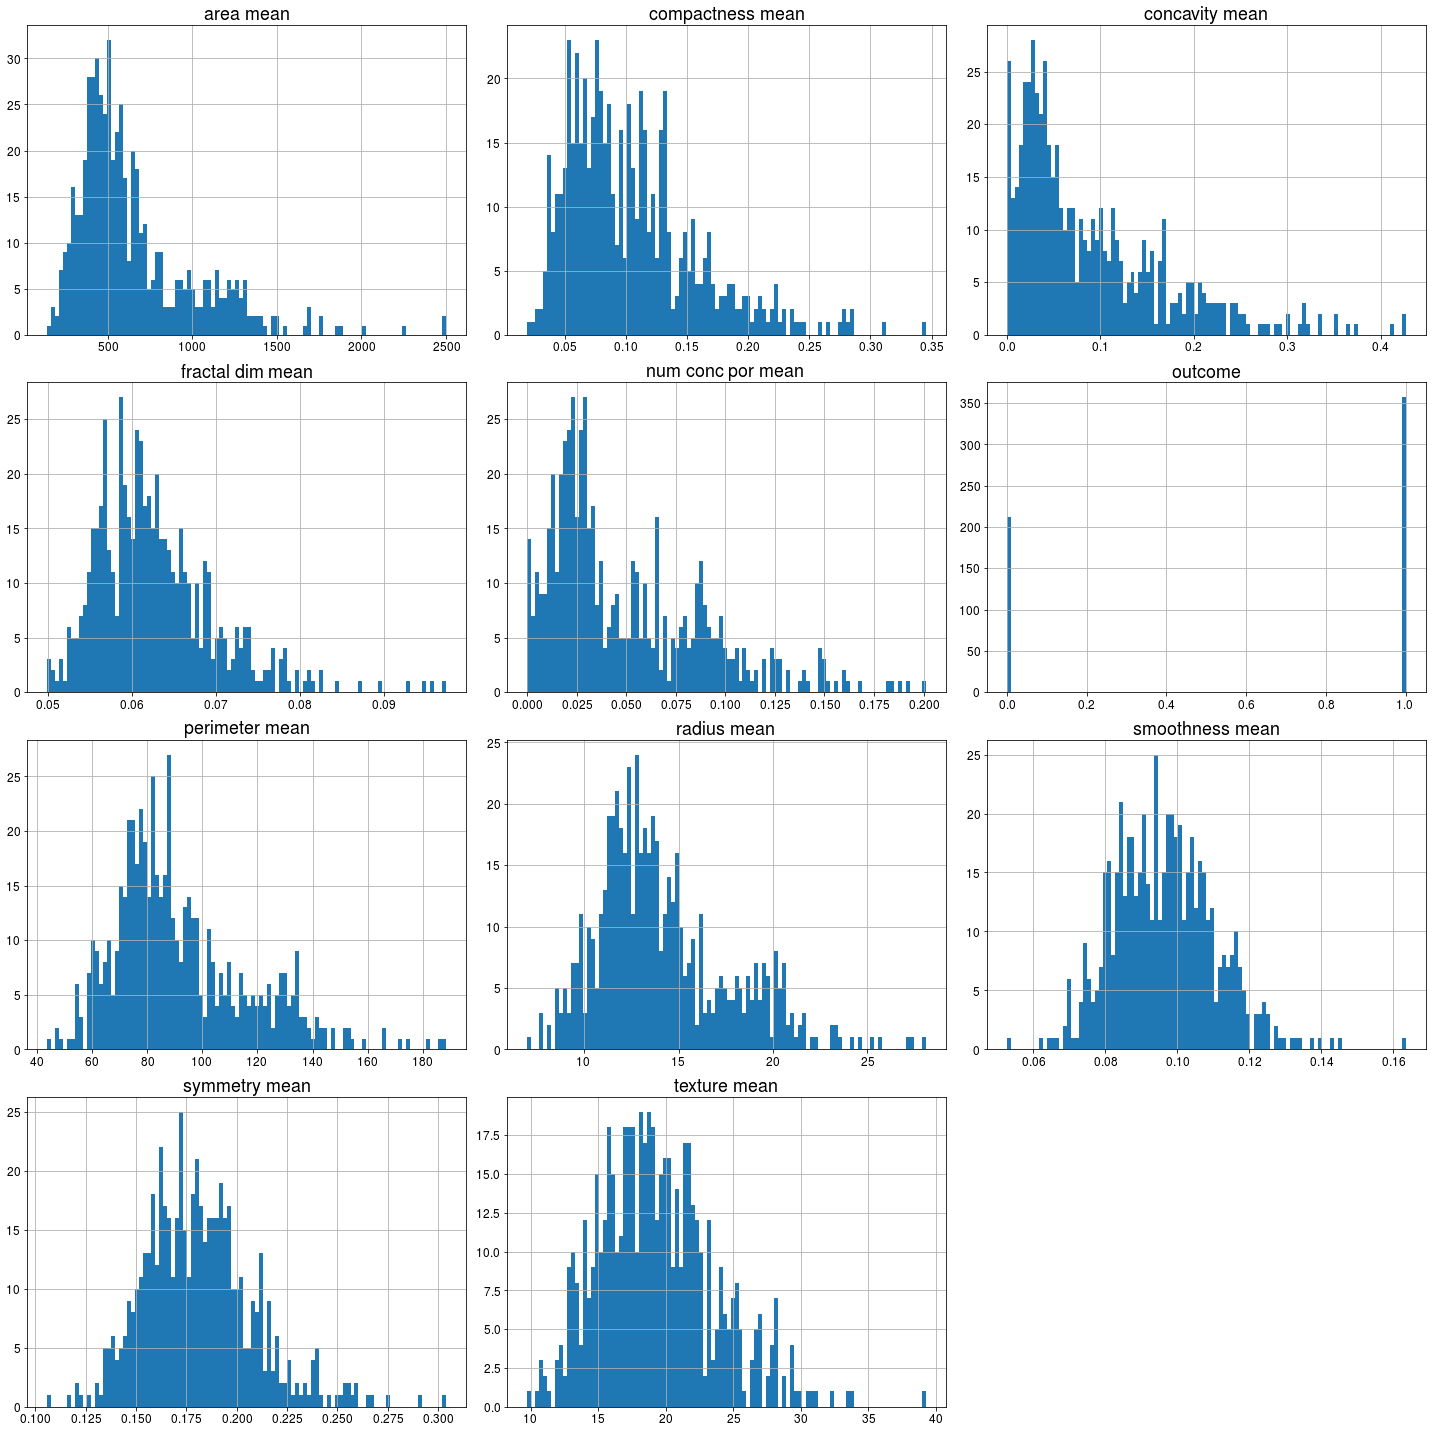

In [11]:
# Latex has issues with underscores therefore we change the title names and replace _ with ""
df_copy = df.copy()
target_names = [x.replace('_',' ') for x in list(df_copy.columns.values)] 
df_copy.rename(columns=dict(zip(df_copy.columns.values,target_names)), inplace=True)
# now plot!
fig =df_copy.iloc[:,:11].hist(figsize=(20, 20),bins = 100,xlabelsize=12,ylabelsize=12)
[x.title.set_size(18) for x in fig.ravel()]
plt.tight_layout()
plt.show()

One way to quantify the correlation between the two variables is to calculate *Pearson moment of correlation*. For a sample, Pearson's correlation coefficient is defined as:

$$
{\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}
$$

This dataset has a lot of features and correlation plot is a nice way to take an overall look at these features and their correlations. We can use *Correlation Plot* to observe the correlation (defined above). We look at the mean values.

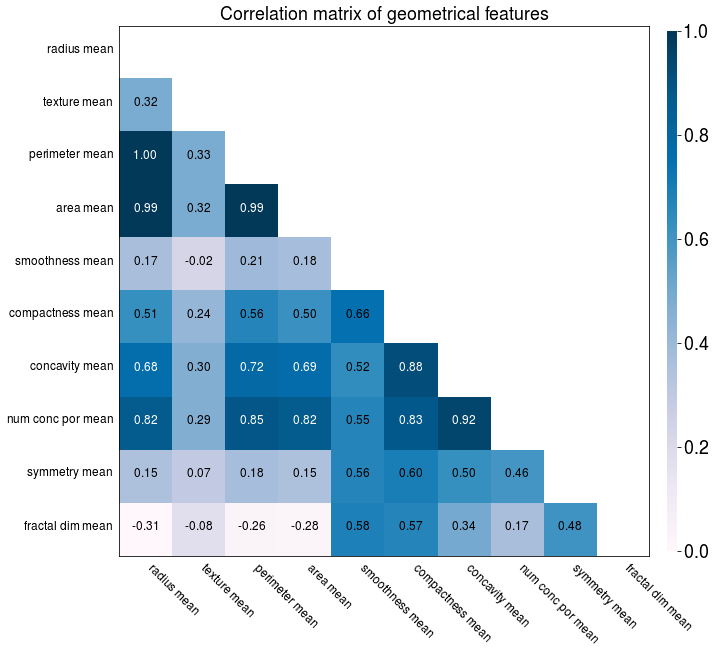

In [12]:
#target_names = [x.replace('_',' ').split()[0]+'(mean)' for x in list(df.columns.values[1:11])]
corr(df.iloc[:,1:11].corr().values,
     target_names = list(df.columns[This dataset has a lot of features and correlation plot is a nice way to take an overall look at these features and their correlations. We can use *Correlation Plot* to observe the correlation (defined above). We look at the mean values.1:11]),
     title_name='geometrical features',
     colmap='PuBu',masked=True)

<div class="warn">
    
There are two groups of features that exhibit high correlations:

-*area,radius,perimeter*

-*concavity,concave points,compactness*
</div>

This means instead of using all of them as feature variables, we will use one of them because high correlation between them means that the two feature vectors are close to parallel and including more than one of them in feature variables not only helps but also may cause numerical instabilities in computing matrix inverses.

In [13]:
selected_feature_variables = ['texture mean','area mean','smoothness mean',
                              'compactness mean','symmetry mean','fractal dim mean']

In order to train different models using our data, we split the data into train and test groups

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state=0)
X_train = train[selected_feature_variables]
y_train = train['outcome']
X_test = test[selected_feature_variables]
y_test = test['outcome']

In [25]:
X_train.head(5)

,texture mean,area mean,smoothness mean,compactness mean,symmetry mean,fractal dim mean
338,17.530,310.800,0.101,0.073,0.189,0.063
427,21.980,359.900,0.088,0.057,0.202,0.060
406,14.860,800.000,0.095,0.085,0.173,0.059
96,17.840,451.100,0.104,0.071,0.190,0.066
490,22.440,466.500,0.082,0.052,0.154,0.060


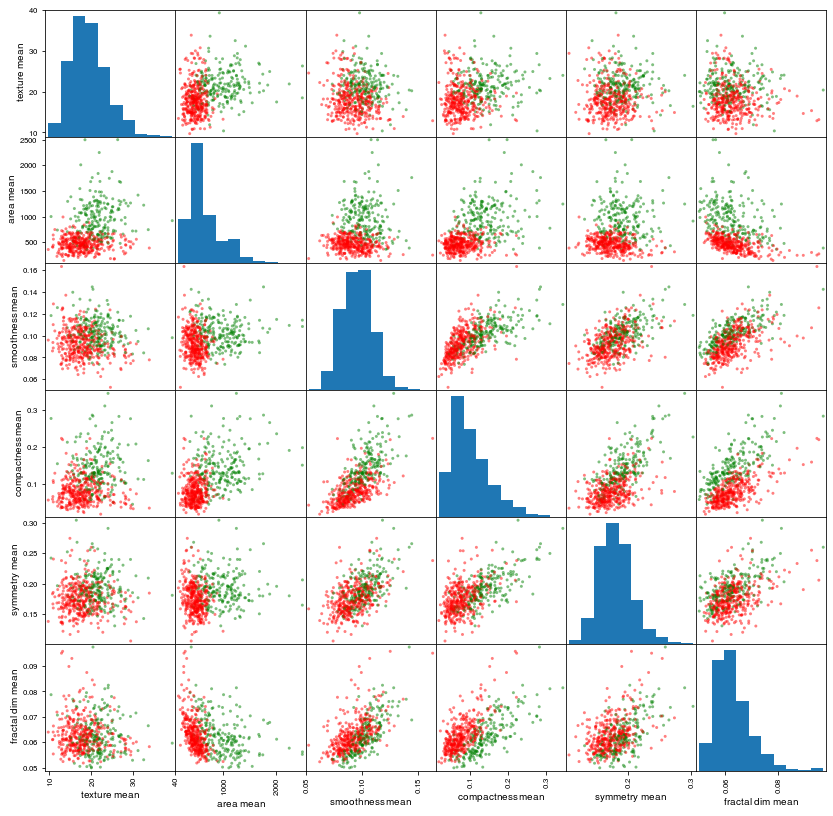

In [26]:
colors = df["outcome"].map(lambda x: {0: "green", 1: "red"}.get(x))
pd.plotting.scatter_matrix(df[selected_feature_variables], c=colors, alpha = 0.5, figsize = (14, 14)); # plotting scatter plot matrix

## Training the models

We will traing a whole host of classification algorithms and compare their performance

In [16]:
from sklearn.neighbors import KNeighborsClassifier #kNN
from sklearn.svm import SVC, LinearSVC #SVC #LSVC
from sklearn.naive_bayes import GaussianNB #GNB
from sklearn.linear_model import LogisticRegression #LR
from sklearn.neural_network import MLPClassifier #MLP
from sklearn.tree import DecisionTreeClassifier #DT
from sklearn.ensemble import GradientBoostingClassifier #GB
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.model_selection import GridSearchCV# for tuning parameter
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, \
                            classification_report, roc_curve, precision_recall_curve, \
                            auc

| Algorithm | kNN | LSVC | SVC | GNB | LR | MLP |DT|
| :-: | :-  | :-  | :-  | :-  | :-  | :-  | :-  |
| Accuracy  |  |  |  | |  |  | |

Note: We apply `StandardScaler` to the models beofre fitting

In [17]:
from sklearn.preprocessing import StandardScaler

### kNN estimator:

In [27]:
num_neighbor=int(np.sqrt(len(X_train)))
pipe_kNN = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=num_neighbor))
pipe_kNN.fit(X_train, y_train)
y_pred_tr = pipe_kNN.predict(X_train)
y_pred = pipe_kNN.predict(X_test)
print("kNN score (test): {:.2f}% \nkNN score (train): {:.2f}% "\
      .format(np.mean(y_pred == y_test)*100,
              np.mean(y_pred_tr == y_train)*100))

kNN score (test): 91.23% 
kNN score (train): 94.73% 


| Algorithm | kNN | LSVC | SVC | GNB | LR | MLP |DT|
| :-: | :-  | :-  | :-  | :-  | :-  | :-  | :-  |
| Accuracy  |91.23|  |  |  |  |  |

or using `sklearn.metrics.accuracy_score`

In [28]:
print('{:.2f}%'.format(accuracy_score(y_pred,y_test)*100))

91.23%


### LinearSVC:

In [29]:
%%time
from sklearn.preprocessing import StandardScaler
pipe_LSVC = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
pipe_LSVC.fit(X_train, y_train)
y_pred_tr = pipe_LSVC.predict(X_train)
y_pred = pipe_LSVC.predict(X_test)
print("LSVC score (test): {:.2f}% \nLSVC score (train): {:.2f}% "\
      .format(np.mean(y_pred == y_test)*100,
              np.mean(y_pred_tr == y_train)*100))

LSVC score (test): 90.35% 
LSVC score (train): 94.51% 
CPU times: user 14.1 ms, sys: 1.95 ms, total: 16.1 ms
Wall time: 14.3 ms


| Algorithm | kNN | LSVC | SVC | GNB | LR | MLP |DT|
| :-: | :-  | :-  | :-  | :-  | :-  | :-  | :-  |
| Accuracy  |91.23|90.35|  |  |  |  |  | 

### SVC:

In [30]:
%%time
for kern in ['linear', 'poly', 'rbf', 'sigmoid']:
    pipe_SVC = make_pipeline(StandardScaler(),SVC(random_state=0, kernel=kern, tol=1e-5))
    pipe_SVC.fit(X_train, y_train)
    y_pred_tr = pipe_SVC.predict(X_train)
    y_pred = pipe_SVC.predict(X_test)
    print("SVC(kernel='{:s}') score (test): {:.2f}% \nSVC score (train): {:.2f}% \n"\
          .format(kern,
                  np.mean(y_pred == y_test)*100,
                  np.mean(y_pred_tr == y_train)*100))

SVC(kernel='linear') score (test): 90.35% 
SVC score (train): 94.51% 

SVC(kernel='poly') score (test): 91.23% 
SVC score (train): 89.45% 

SVC(kernel='rbf') score (test): 89.47% 
SVC score (train): 95.16% 

SVC(kernel='sigmoid') score (test): 83.33% 
SVC score (train): 84.84% 

CPU times: user 65.5 ms, sys: 3.5 ms, total: 69 ms
Wall time: 66.7 ms


| Algorithm | kNN | LSVC | SVC (kernel = 'lin','poly','rbf','sig') | GNB | LR | MLP |DT|
| :-: | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | 
| Accuracy  |91.23|90.35|90.35,91.23,89.47,83.33|  |  |  |  |

### Gaussian NB:

In [31]:
%%time
pipe_GNB = make_pipeline(StandardScaler(),GaussianNB())
pipe_GNB.fit(X_train, y_train)
y_pred_tr = pipe_GNB.predict(X_train)
y_pred = pipe_GNB.predict(X_test)
print("GNB score (test): {:.2f}% \nGNB score (train): {:.2f}% "\
      .format(np.mean(y_pred == y_test)*100,
              np.mean(y_pred_tr == y_train)*100))

GNB score (test): 89.47% 
GNB score (train): 91.21% 
CPU times: user 11.9 ms, sys: 2.11 ms, total: 14 ms
Wall time: 12.3 ms


| Algorithm | kNN | LSVC | SVC (kernel = 'lin','poly','rbf','sig') | GNB | LR | MLP |DT|
| :-: | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | 
| Accuracy  |91.23|90.35|90.35,91.23,89.47,83.33|89.47|  |  |  |

### Logistic Regression:

In [32]:
%%time
for c in [0.01,0.1,1,10]:
    pipe_LR = make_pipeline(StandardScaler(),LogisticRegression(C=c, random_state=0))
    pipe_LR.fit(X_train, y_train)
    y_pred_tr = pipe_LR.predict(X_train)
    y_pred = pipe_LR.predict(X_test)
    print("LR score (C={:.2f}, test): {:.2f}%\nLR score (train): {:.2f}% \n"\
          .format(c,
                  np.mean(y_pred == y_test)*100,
                  np.mean(y_pred_tr == y_train)*100))

LR score (C=0.01, test): 87.72%
LR score (train): 89.23% 

LR score (C=0.10, test): 93.86%
LR score (train): 93.19% 

LR score (C=1.00, test): 91.23%
LR score (train): 94.29% 

LR score (C=10.00, test): 90.35%
LR score (train): 94.51% 

CPU times: user 145 ms, sys: 6.49 ms, total: 151 ms
Wall time: 80.7 ms


| Algorithm | kNN | LSVC | SVC (kernel = 'lin','poly','rbf','sig') | GNB | LR (C=0.01,0.1,1,10) | MLP |DT|
| :-: | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  |
| Accuracy |91.23|90.35|90.35,91.23,89.47,83.33|89.47|87.72,93.86,91.23,90.35|  | 

### MLP (Multi-Layer Perceptron):

In [33]:
%%time
pipe_MLP = make_pipeline(StandardScaler(),MLPClassifier())
pipe_MLP.fit(X_train, y_train.values.ravel())
y_pred_tr = pipe_MLP.predict(X_train)
y_pred = pipe_MLP.predict(X_test)
print("MLP score (test): {:.2f}% \nMLP score (train): {:.2f}% "\
      .format(np.mean(y_pred == y_test)*100,
              np.mean(y_pred_tr == y_train)*100))

MLP score (test): 90.35% 
MLP score (train): 96.70% 
CPU times: user 1.1 s, sys: 29.5 ms, total: 1.13 s
Wall time: 678 ms


| Algorithm | kNN | LSVC | SVC (kernel = 'lin','poly','rbf','sig') | GNB | LR (C=0.01,0.1,1,10) | MLP | DT| 
| :-: | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | 
| Accuracy |91.23|90.35|90.35,91.23,89.47,83.33|89.47|87.72,93.86,91.23,90.35|90.35

### DT (Decision Tree):

In [34]:
%%time
pipe_DT = make_pipeline(DecisionTreeClassifier())
pipe_DT.fit(X_train, y_train)
y_pred_tr = pipe_DT.predict(X_train)
y_pred = pipe_MLP.predict(X_test)
print("DT score (test): {:.2f}% \nDT score (train): {:.2f}% "\
      .format(np.mean(y_pred == y_test)*100,
              np.mean(y_pred_tr == y_train)*100))

DT score (test): 90.35% 
DT score (train): 100.00% 
CPU times: user 11.6 ms, sys: 1.91 ms, total: 13.5 ms
Wall time: 10.4 ms


| Algorithm | kNN | LSVC | SVC (kernel = 'lin','poly','rbf','sig') | GNB | LR (C=0.01,0.1,1,10) | MLP | DT| 
| :-: | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | :-:  | 
| Accuracy |91.23|90.35|90.35,91.23,89.47,83.33|89.47|87.72,93.86,91.23,90.35|90.35|90.35

Looking at the train vs. test accuracies, we note that some of the models that we assessed their performance exhibit **over/under**-fitting. As we know most of these models come with a lot of **hyperparameters** that are required to be tuned to get the best performance. It would be hard to find exactly what hyperparameters work best for each model but one of the useful methods to make sure that the model is not **over/under**-fitting is *k-fold* cross validation.

In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

def kfold(df, model, feature_column_names, 
          observation_column_name, nfold=10, print_every_fold_score=True):
    
    kf = KFold(n_splits=nfold)
    error = []
    counter=0
    for train_ids, test_ids in kf.split(df):
        train_X = (df[feature_column_names].iloc[train_ids,:])# in this iloc is used for index of trainig data
        train_y = df[observation_column_name].iloc[train_ids]# here is only column so it repersenting only row in train
        model.fit(train_X, train_y)
        test_X=df[feature_column_names].iloc[test_ids,:]
        test_y=df[observation_column_name].iloc[test_ids]
        if print_every_fold_score:
            print("Fold {:d} score: {:.2f}%".format(counter+1,model.score(test_X,test_y)*100))
        counter+=1
        error.append(model.score(test_X,test_y))
        
    print("Cross-Validation Score : %s" % "{0:.2f}%".format(np.mean(error)*100))


### For example in the last model:

In [37]:
kfold(df, pipe_MLP, selected_feature_variables, 'outcome', nfold=10)

Fold 1 score: 82.46%
Fold 2 score: 92.98%
Fold 3 score: 91.23%
Fold 4 score: 91.23%
Fold 5 score: 98.25%
Fold 6 score: 98.25%
Fold 7 score: 94.74%
Fold 8 score: 96.49%
Fold 9 score: 94.74%
Fold 10 score: 89.29%
Cross-Validation Score : 92.96%


We would like to also include ***precision, recall, f1-score*** and other performance metrics for each model which are valuable assets in the problems where one class (**Malignant**) has a higher significance than the other (**Benign**). In this problem, the case where the model makes a false prediction and classifies a **Benign** tumor as **Malignant** is not as **problematic** as the opposite case, where a **Malignant** tumor is being classified as **Benign**. The next few paragraphs will talk about other important metrics to assess the accuracy of a model.

## Important metrics to evaluate the model performance

#### precision, recall, false alarm, AUC-ROC ...

Many classifiers are able to quantify their uncertainty about the answer by outputting a probability value, using, for example, Bayes decision theory.

To calculate the accuracy of a classifier from probabilities you need a **threshold** to decide when $0$ turns into $1$. The most intuitive threshold is of course $0.5$

Remember the **confusion matrix** ($\textbf{A}:1  -  \textbf{not A}:0 $):

\begin{gather*}
\  &\text{True value is }\textbf{A}    &\text{True value is }\textbf{not A}    &\Sigma   \\
\hline
\text{Model predicts:    } \textbf{A}     &\color{green}{\textbf{true}}\text{ positive }(\textit{TP})  &\color{red}{\textbf{false}}\text{ positive }(\textit{FP})   &\hat{N}_{+}=TP+FP \\
\text{Model predicts:    } \textbf{Not A}  &\color{red}{\textbf{false}}\text{ negative }(\textit{FN})   &\color{green}{\textbf{true}}\text{ negative }(\textit{TN})    &\hat{N}_{-}=FN+TN \\
\ &N^{+}=TP+FN   &N^{-}=FP+TN     & N = N^{+}+N^{-} = \hat{N}_{+}+\hat{N}_{-}
\end{gather*}

**Sensitivity, recall, or true positive rate (TPR)** is defined as 

$$
{\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {N^+} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR}=1- \frac {\mathrm {FN} }{\mathrm {N^+} }}$$

**False alarm rate or false positive rate (FPR)**

$$
{\displaystyle \mathrm {FPR} ={\frac {\mathrm {FP} }{\mathrm {N^-} }}={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}=1-\mathrm {TNR}=1- \frac {\mathrm {TN} }{\mathrm {N^-} }} 
$$

**Precision or positive predictive value (PPV)**

$$
{\displaystyle \mathrm {PPV} =\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FP} }}
$$

Note that **Accuracy** is basically:
$$
\frac {\mathrm {TP+TN} }{\mathrm {TP+TN+FP+FN}}=\frac {\mathrm {TP+TN} }{N}
$$

Now let's take a look at an example:

`y_test           = [ 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1] ==> True values
 p_pred           = [.6,.4,.6,.9,.2,.6,.4,.8,.3,.7,.4] ==> probabilities
 y_test_predicted = [ 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0] ==> 0s and 1s (if probability > 0.5 equals 1 otherwise 0)
`

`y_test_predicted` is obtained when **the decision threshold is 0.5**. For the above definitions we then have:

\begin{gather*}
 &\textbf{True value: 1}    &\textbf{True value: 0} \\[1ex]
\text{Model predicts    } \textbf{1}  &\textbf{TP}=4  &\textbf{FP}=2 \\
\text{Model predicts    } \textbf{0}  &\textbf{FN}=2  &\textbf{TN}=3
\end{gather*}

\begin{gather*}
 \mathrm{TPR}=\frac{4}{4+2}=0.67 &\quad &\mathrm{FPR}=\frac{2}{2+3}=0.4
\end{gather*}

Now let's suppose we change the **decision threshold to 0.65**. This means that:

`y_test           = [ 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1] ==> True values
 p_pred           = [.6,.4,.6,.9,.2,.6,.4,.8,.3,.7,.4] ==> probabilities
 y_test_predicted = [ 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0] ==> 0s and 1s (if probability > 0.65 equals 1 otherwise 0)
`

\begin{gather*}
 &\textbf{True value: 1}    &\textbf{True value: 0} \\[1ex]
\text{Model predicts    } \textbf{1}  &\textbf{TP}=3  &\textbf{FP}=0 \\
\text{Model predicts    } \textbf{0}  &\textbf{FN}=3  &\textbf{TN}=5
\end{gather*}

\begin{gather*}
 \mathrm{TPR}=\frac{3}{3+3}=0.5 &\quad &\mathrm{FPR}=\frac{0}{5+0}=0
\end{gather*}



For example for the previous example (Decision tree classifier):

In [38]:
print(confusion_matrix(y_test,y_pred))

[[44  3]
 [ 8 59]]


This means that the DT model:
    
- predicted 59 out of 67 **Malignant** tumors <font color='green'>correctly</font>.

- predicted 8 out of 67 **Malignant** tumors <font color='red'>incorrectly</font>.

- predicted 44 out of 47 **Benign** tumors <font color='green'>correctly</font>.

- predicted 3 out of 47 **Benign** tumors <font color='red'>incorrectly</font>.

Note that the 1 wrong prediction for **Malignant** tumors might be far more important than the 7 wrong preditions for the **Benign** tumor!

In [40]:
print(classification_report(y_test,y_pred,target_names=['Benign','Malignant'],digits=3))

              precision    recall  f1-score   support

      Benign      0.846     0.936     0.889        47
   Malignant      0.952     0.881     0.915        67

    accuracy                          0.904       114
   macro avg      0.899     0.908     0.902       114
weighted avg      0.908     0.904     0.904       114



**AUC**, or **Area Under Curve**, is a metric for binary classification. It’s probably the second most popular one, after accuracy.

A **receiver operating characteristic** curve, or **ROC** curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied, like the example above. AUC_ROC is the most reliable approach when we deal with **imbalanced problems.** It is a chart that visualizes the tradeoff between true positive rate (**TPR**) and false positive rate (**FPR**). Basically, for every threshold, we calculate TPR and FPR and plot it on one chart.

**AUC-ROC** means area under the **ROC** curve. Of course, the higher **TPR** and the lower **FPR** is for each threshold the better and so classifiers that have curves that are more top-left-side are better.

**AUC-PR** on the other hand means area under the **Precision-Recall** Curve. 
The Precision-Recall AUC is just like the ROC AUC, in that it summarizes the curve with a range of threshold values as a single score. The score can then be used as a point of comparison between different models on a binary classification problem where a score of 1.0 represents a model with perfect skill.



### AUC-ROC

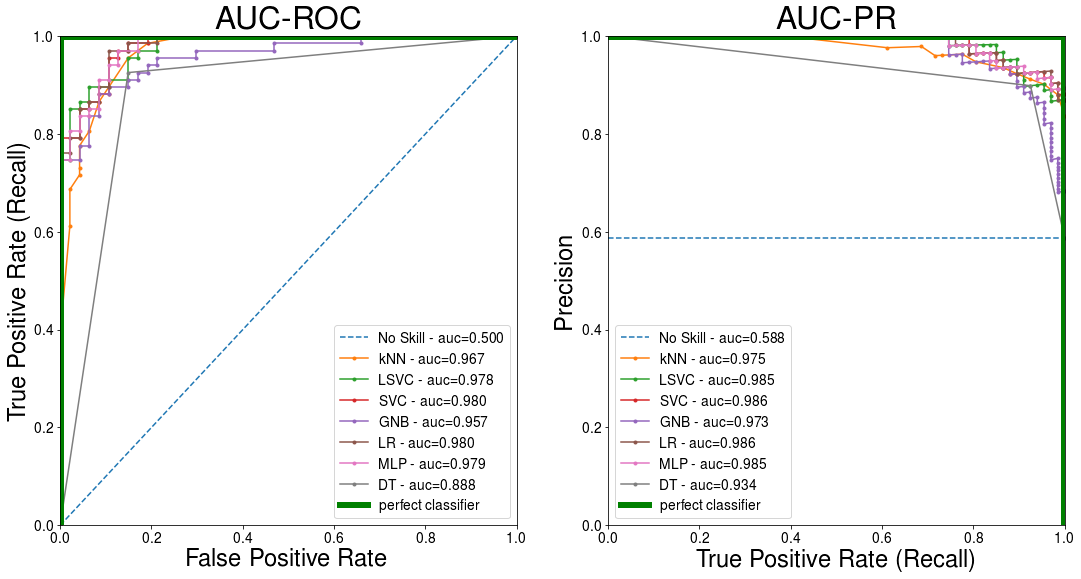

In [54]:
fig, ax = plt.subplots(1,2,figsize=(18, 9))

pipe_kNN = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=num_neighbor))
pipe_kNN.fit(X_train, y_train)

pipe_LSVC = make_pipeline(StandardScaler(),SVC(random_state=0, kernel='linear', tol=1e-5, probability=True))
# because 'LinearSVC' object has no attribute 'predict_proba'
# or use _predict_proba_lr for LSVC
pipe_LSVC.fit(X_train, y_train)

pipe_SVC = make_pipeline(StandardScaler(),SVC(random_state=0, kernel='rbf', tol=1e-5, probability=True))
pipe_SVC.fit(X_train, y_train)

pipe_GNB = make_pipeline(StandardScaler(),GaussianNB())
pipe_GNB.fit(X_train, y_train)

pipe_LR = make_pipeline(StandardScaler(),LogisticRegression(C=1, random_state=0))
pipe_LR.fit(X_train, y_train)

pipe_MLP = make_pipeline(StandardScaler(),MLPClassifier())
pipe_MLP.fit(X_train, y_train.values.ravel())

pipe_DT = make_pipeline(DecisionTreeClassifier())
pipe_DT.fit(X_train, y_train)

models = [pipe_kNN, pipe_SVC, pipe_LSVC, pipe_GNB, pipe_LR, pipe_MLP, pipe_DT]
tags = ['kNN','LSVC','SVC','GNB','LR','MLP','DT']

ns_probs = np.zeros(len(y_test))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ns_score = roc_auc_score(y_test, ns_probs)
ax[0].plot(ns_fpr, ns_tpr, linestyle='--', label="{0:s} - auc={1:.3f}".format('No Skill', ns_score))

no_skill = len(y_test[y_test==1]) / len(y_test)
ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label="{0:s} - auc={1:.3f}".format('No Skill', no_skill))

for model, tag in zip(models, tags):
    model_probs = model.predict_proba(X_test)[:, 1]
    score_roc_auc = roc_auc_score(y_test, model_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
    ax[0].plot(model_fpr, model_tpr, marker='.', label="{0:s} - auc={1:.3f}".format(tag, score_roc_auc))
    model_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    auc_pr_score = auc(recall, precision)
    ax[1].plot(recall, precision, marker='.', label="{0:s} - auc={1:.3f}".format(tag, auc_pr_score))
    
ax[0].plot([0.001,0.001,0.999],[0.001,0.999,0.999],'g-',Linewidth=6,label='perfect classifier')
ax[0].set_xlabel('False Positive Rate',Fontsize=24)
ax[0].set_ylabel('True Positive Rate (Recall)',Fontsize=24)
ax[0].set_title('AUC-ROC',Fontsize=32)
ax[1].plot([0.001,0.999,0.999],[0.999,0.999,0.001],'g-',Linewidth=6,label='perfect classifier')
ax[1].set_xlabel('True Positive Rate (Recall)',Fontsize=24)
ax[1].set_ylabel('Precision',Fontsize=24)
ax[1].set_title('AUC-PR',Fontsize=32)

for i in range(2):
    for tick in ax[i].xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in ax[i].yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    ax[i].legend(prop={'size': 14})
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([0,1])

# show the plot
plt.show()